# Setup

In [1]:
# Image processing
import SimpleITK as sitk
import numpy as np

# Image rendering
import matplotlib.pyplot as plt

%matplotlib inline
from ipywidgets import interact, fixed

# Miscellaneous
from pathlib import Path
from pprint import pprint
from rotations_helpers import degrees_to_radians, disp_slice, resample_2d_rotation, resample_3d_rotation

# Set up directories
# When running the Jupyter notebook, cwd() is TechTalk/src/
HOME_DIR = Path.cwd().parents[0]
EXAMPLE_DATA_DIR = HOME_DIR / "ExampleData"

# The extensions we support in our project. Not a complete list.
# See https://simpleitk.readthedocs.io/en/master/IO.html for everything that sitk supports.
SUPPORTED_EXTENSIONS: tuple = ("*.nii.gz", "*.nii", "*.nrrd")

EXAMPLE_DATA_PATHS: list[Path] = list()
for extension in SUPPORTED_EXTENSIONS:
    for path in EXAMPLE_DATA_DIR.glob(extension):
        EXAMPLE_DATA_PATHS.append(path)

# Read image

Create a `sitk.ImageFileReader` to read files, then store the images in variables.

[List of extensions supported](https://simpleitk.readthedocs.io/en/master/IO.html)

In [2]:
READER: sitk.ImageFileReader = sitk.ImageFileReader()

nifti_path: Path = EXAMPLE_DATA_PATHS[0]
READER.SetFileName(str(nifti_path))
nifti_image: sitk.Image = READER.Execute()

nrrd_path: Path = EXAMPLE_DATA_PATHS[-1]
# We need only give ImageFileReader a file path.
# It will automatically detect the file type.
READER.SetFileName(str(nrrd_path))
nrrd_image: sitk.Image = READER.Execute()

# Print the 4 properties of a `sitk.Image`

* Origin
* Size
* Spacing
* Direction matrix

In [3]:
properties: dict = {
    "origin": nifti_image.GetOrigin(),
    "size": nifti_image.GetSize(),
    "spacing": nifti_image.GetSpacing(),
    "direction": nifti_image.GetDirection(),
}
ORIGIN = properties["origin"]
SIZE = properties["size"]
SPACING = properties["spacing"]
DIRECTION = properties["direction"]

properties

{'origin': (96.10041046142578, 134.1010284423828, -72.0984878540039),
 'size': (244, 292, 198),
 'spacing': (0.7991799712181091, 0.7979450225830078, 0.8030300140380859),
 'direction': (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)}

# Display the middle z slice

Here, we have to convert the `sitk.Image` to a `numpy` array to render it in this notebook.

In our project, we also have to convert to `numpy` array to render in the GUI.

Essentially, numpy is a secondary image processing/rendering library.

(-0.5, 243.5, 291.5, -0.5)

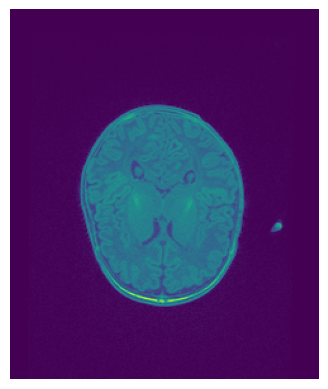

In [4]:
z_center: int = int((SIZE[2] - 1) / 2)
slice: sitk.Image = nifti_image[:, :, z_center]

# Convert sitk.Image to numpy array
# NOTE: This returns the transpose of the sitk representation
slice_np: np.ndarray = sitk.GetArrayFromImage(slice)

plt.imshow(slice_np)
plt.axis("off")

# However, SimpleITK and numpy indexing are in [opposite order](https://simpleitk.org/SPIE2019_COURSE/02_images_and_resampling.html#SimpleITK2Numpy-and-Numpy2SimpleITK)!

SimpleITK: `[x, y, z]`

numpy: `[z, y, x]`

In [5]:
print(f"sitk.Image dimensions: {SIZE}")
nifti_image_np: np.ndarray = sitk.GetArrayFromImage(nifti_image)
print(f"ndarray dimensions: {nifti_image_np.shape}")

# Looping over all values would take too long
for x in range(0, SIZE[0], 25):
    for y in range(0, SIZE[1], 25):
        for z in range(0, SIZE[2], 25):
            assert nifti_image.GetPixel(x, y, z) == nifti_image_np[z][y][x]

sitk.Image dimensions: (244, 292, 198)
ndarray dimensions: (198, 292, 244)


# Orient the image to follow ITK-SNAP radiological conventions

ITK-SNAP is an official medical image viewer. Let's orient this image for the **axial view** using the [`DICOMOrientImageFilter`](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1DICOMOrientImageFilter.html#details).

![NIfTI image in ITK-SNAP](../img/NIfTI_ITKSNAP_annotated.png)

(-0.5, 243.5, 291.5, -0.5)

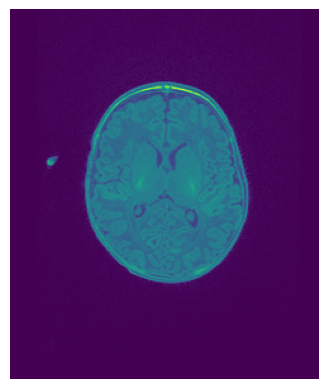

In [6]:
AXIAL_ORIENTATION_STR = "LPS"
ORIENT_FILTER: sitk.DICOMOrientImageFilter = sitk.DICOMOrientImageFilter()
ORIENT_FILTER.SetDesiredCoordinateOrientation(AXIAL_ORIENTATION_STR)

nifti_axial: sitk.Image = ORIENT_FILTER.Execute(nifti_image)

slice_axial: sitk.Image = nifti_axial[:, :, z_center]
slice_axial_np: np.ndarray = sitk.GetArrayFromImage(slice_axial)
plt.imshow(slice_axial_np)
plt.axis("off")

# Which of the four properties did `DICOMOrientImageFilter` change?

In [7]:
properties_axial: dict = {
    "origin": nifti_axial.GetOrigin(),
    "size": nifti_axial.GetSize(),
    "spacing": nifti_axial.GetSpacing(),
    "direction": nifti_axial.GetDirection(),
}
ORIGIN_AXIAL = properties_axial["origin"]
SIZE_AXIAL = properties_axial["size"]
SPACING_AXIAL = properties_axial["spacing"]
DIRECTION_AXIAL = properties_axial["direction"]

print("nifti_image")
pprint(properties)
print()
print("nifti_axial")
pprint(properties_axial)

nifti_image
{'direction': (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0),
 'origin': (96.10041046142578, 134.1010284423828, -72.0984878540039),
 'size': (244, 292, 198),
 'spacing': (0.7991799712181091, 0.7979450225830078, 0.8030300140380859)}

nifti_axial
{'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
 'origin': (-98.10032254457474, -98.10097312927246, -72.0984878540039),
 'size': (244, 292, 198),
 'spacing': (0.7991799712181091, 0.7979450225830078, 0.8030300140380859)}


# 2D rotations using `Euler2DTransform`

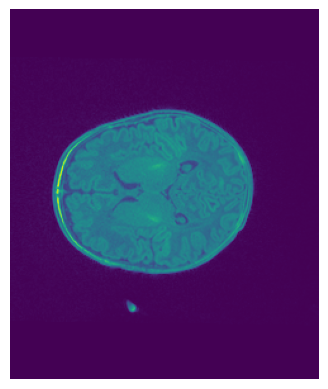

In [8]:
euler_2d_transform: sitk.Euler2DTransform = sitk.Euler2DTransform()
euler_2d_transform.SetCenter(
    slice_axial.TransformContinuousIndexToPhysicalPoint(
        [(dimension - 1) / 2.0 for dimension in slice_axial.GetSize()]
    )
)

euler_2d_transform.SetAngle(degrees_to_radians(90))

rotated_slice: sitk.Image = sitk.Resample(slice_axial, euler_2d_transform)
disp_slice(rotated_slice)


# Interactive 2D rotations

In [9]:
interact(
    resample_2d_rotation,
    img_2d=fixed(slice_axial),
    euler_2d_transform = fixed(euler_2d_transform),
    theta=(0, 360)
)

interactive(children=(IntSlider(value=180, description='theta', max=360), Output()), _dom_classes=('widget-int…

<function rotations_helpers.resample_2d_rotation(img_2d: SimpleITK.SimpleITK.Image, euler_2d_transform: SimpleITK.SimpleITK.Euler2DTransform, theta) -> None>

# 3D rotations using `Euler3DTransform`

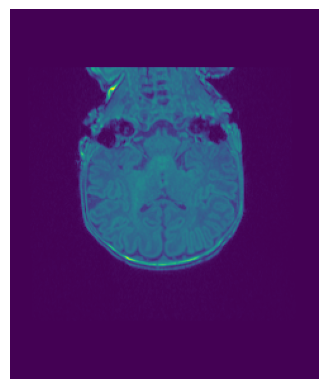

In [10]:
euler_3d_transform: sitk.Euler3DTransform = sitk.Euler3DTransform()
euler_3d_transform.SetCenter(
    nifti_axial.TransformContinuousIndexToPhysicalPoint(
        [(dimension - 1) / 2.0 for dimension in nifti_axial.GetSize()]
    )
)

euler_3d_transform.SetRotation(degrees_to_radians(90), degrees_to_radians(90), degrees_to_radians(90))

rotated_3d: sitk.Image = sitk.Resample(nifti_axial, euler_3d_transform)
rotated_slice = rotated_3d[:, :, z_center]
disp_slice(rotated_slice)


# Interactive 3D rotations

In [11]:
interact(
    resample_3d_rotation,
    img_3d=fixed(nifti_axial),
    euler_3d_transform = fixed(euler_3d_transform),
    theta_x=(0, 360),
    theta_y=(0, 360),
    theta_z=(0, 360),
    slice=(0, nifti_axial.GetSize()[2]-1)
)

interactive(children=(IntSlider(value=180, description='theta_x', max=360), IntSlider(value=180, description='…

<function rotations_helpers.resample_3d_rotation(img_3d: SimpleITK.SimpleITK.Image, euler_3d_transform: SimpleITK.SimpleITK.Euler3DTransform, theta_x, theta_y, theta_z, slice) -> None>